In [2]:
!pip install natasha -q

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)


In [90]:
import re
import pandas as pd
import numpy as np
from gensim.models import Word2Vec, Doc2Vec
from gensim import corpora
from pprint import pprint
import gensim.downloader as api
from gensim.utils import simple_preprocess
from gensim import models
from multiprocessing import cpu_count
from gensim.models.word2vec import Word2Vec
import string
from gensim.models import KeyedVectors

In [91]:
# Объеденяем датасеты
shyn = pd.read_csv('/kaggle/input/tuvan-language-in-articles/tuva_text.csv')
gov = pd.read_csv('/kaggle/input/tuvan-language-in-articles/govtuva.csv')
shelesh = pd.read_csv('/kaggle/input/tuvan-language-in-articles/chelesh.csv')

shyn.columns = ['id','text']
gov.columns = ['id','text']
shelesh.columns = ['id','text']

data = pd.concat([shyn,gov, shelesh], ignore_index=True)
del data['id']
data.dropna
df = data

In [92]:
def clear_preprocessor(word):
    word_out = []
    word = [x for x in word.split()] 
    for x in word:
        if x.isalpha():
            word_out.append(x.lower())
    return word_out


df['text_pre'] = df['text'].apply(lambda x: clear_preprocessor(x))
df

,text,text_pre
0,Республиканың Сүт-Хөл болгаш Бии-Хем кожууннар...,"[республиканың, болгаш, кожууннарның, хире, ге..."
1,Дыштаныр хүннерде республиканың найысылалынга ...,"[дыштаныр, хүннерде, республиканың, найысылалы..."
2,2020 чылга чедир Россия Федерациязында көдээ д...,"[чылга, чедир, россия, федерациязында, көдээ, ..."
3,"Келир чылын республикага чаа бассейнерниң, фут...","[келир, чылын, республикага, чаа, футбол, шөлд..."
4,"Дүүн, октябрь 26-да, найысылал Кызылдың төөгүл...","[октябрь, найысылал, кызылдың, төөгүлүг, турас..."
...,...,...
8257,\n\nАлександр Шоюн. СалыгынчыгашХӨРТҮК БОЛУП ...,"[александр, салыгынчыгашхөртүк, болуп, хуулуп,..."
8258,\n\nКомбу Бижек. Ховаганнар ХОВАГАННАР\r\n \r\...,"[комбу, ховаганнар, ховаганнар, челээш, чуруп,..."
8259,\n\nКызыл-Эник Кудажы. АнайжыгашБИР ТӨӨГҮ\r\n...,"[анайжыгашбир, төөгү, чаңгыс, хойнуң, чарлыр, ..."
8260,\n\nЛеонид Чадамба. ЧодурааларКЫМ-ДЫР МЕН?\r\n...,"[леонид, ынак, чылыг, бажыңныг, мен, ыяш, дытт..."


In [94]:
data = [x for x in df.text_pre]

In [95]:
my_dictionary = corpora.Dictionary(data)

In [99]:
# преобразование в слов Bag of Word
bow_corpus =[my_dictionary.doc2bow(doc, allow_update = False) for doc in data]
print(len(bow_corpus))

8262


In [100]:
# Вес слова в корпусе Bag of Word
word_weight =[]
for doc in bow_corpus:
    for id, freq in doc:
        word_weight.append([my_dictionary[id], freq])


In [101]:
# создать модель TF-IDF
tfIdf = models.TfidfModel(bow_corpus, smartirs ='ntc')
  
# TF-IDF вес слова
weight_tfidf =[]
for doc in tfIdf[bow_corpus]:
    for id, freq in doc:
        weight_tfidf.append([my_dictionary[id], np.around(freq, decimals=3)])


In [41]:
#w2v_model = Word2Vec(weight_tfidf, min_count=0, workers=cpu_count())

In [102]:
w2v_model = Word2Vec(
    min_count=10,
    window=5,
    negative=10,
    alpha=0.03,
    min_alpha=0.0007,
    sample=6e-5,
    sg=1)

w2v_model.build_vocab(data)

w2v_model.train(data, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

(50916387, 88741590)

In [103]:
w2v_model.wv.most_similar(positive=["республиканың"])

[('тываның', 0.8273658156394958),
 ('тыва', 0.7799330353736877),
 ('болгаш', 0.7682048678398132),
 ('республика', 0.76520174741745),
 ('чазааның', 0.7568621039390564),
 ('база', 0.7351704239845276),
 ('баштыңы', 0.7087673544883728),
 ('баштыңының', 0.6955709457397461),
 ('муниципалдыг', 0.6869267821311951),
 ('хуралының', 0.6865888833999634)]

In [104]:
w2v_model.wv.most_similar(positive=["тыва", "чоон"])

[('ооң', 0.6433651447296143),
 ('кылдыр', 0.6198901534080505),
 ('база', 0.6097442507743835),
 ('ол', 0.596100389957428),
 ('ышкаш', 0.5890752077102661),
 ('чоннуң', 0.5796635746955872),
 ('улуг', 0.5693891048431396),
 ('кончуг', 0.5681724548339844),
 ('тываның', 0.5618339776992798),
 ('деп', 0.5613244771957397)]

In [118]:
w2v_model.wv.most_similar_to_given("тыва", ["чоон", "кызыл"])
print(len(w2v_model.wv))
w2v_model.save('tuva.model')

20246


In [119]:
w2v_model.wv.most_similar(positive='тыва', topn=10)

[('республиканың', 0.779932975769043),
 ('национал', 0.7092649936676025),
 ('тываның', 0.706771194934845),
 ('база', 0.7054527401924133),
 ('республика', 0.6784764528274536),
 ('болгаш', 0.6646707653999329),
 ('россия', 0.6553109288215637),
 ('федерациязының', 0.6519585847854614),
 ('россияның', 0.6450529098510742),
 ('чазааның', 0.6233145594596863)]

In [107]:
print(w2v_model.wv.most_similar(positive='тыва', negative=None, topn=5, restrict_vocab=None, indexer=None))

[('республиканың', 0.779932975769043), ('национал', 0.7092649936676025), ('тываның', 0.706771194934845), ('база', 0.7054527401924133), ('республика', 0.6784764528274536)]


In [108]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

def tsne_scatterplot(model, word, list_names):
    """Plot in seaborn the results from the t-SNE dimensionality reduction 
    algorithm of the vectors of a query word,
    its list of most similar words, and a list of words."""
    vectors_words = [model.wv.word_vec(word)]
    word_labels = [word]
    color_list = ['red']

    close_words = model.wv.most_similar(word)
    for wrd_score in close_words:
        wrd_vector = model.wv.word_vec(wrd_score[0])
        vectors_words.append(wrd_vector)
        word_labels.append(wrd_score[0])
        color_list.append('blue')

    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.word_vec(wrd)
        vectors_words.append(wrd_vector)
        word_labels.append(wrd)
        color_list.append('green')

    # t-SNE reduction
    Y = (TSNE(n_components=2, random_state=0, perplexity=15, init="pca")
        .fit_transform(vectors_words))
    # Sets everything up to plot
    df = pd.DataFrame({"x": [x for x in Y[:, 0]],
                    "y": [y for y in Y[:, 1]],
                    "words": word_labels,
                    "color": color_list})
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    # Basic plot
    p1 = sns.regplot(data=df,
                    x="x",
                    y="y",
                    fit_reg=False,
                    marker="o",
                    scatter_kws={"s": 40,
                                "facecolors": df["color"]}
    )
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
        p1.text(df["x"][line],
                df["y"][line],
                " " + df["words"][line].title(),
                horizontalalignment="left",
                verticalalignment="bottom", size="medium",
                color=df["color"][line],
                weight="normal"
        ).set_size(15)

    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
    plt.title('t-SNE visualization for {}'.format(word.title()))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `word_vec` (Use get_vector instead).
  if __name__ == "__main__":
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `word_vec` (Use get_vector instead).
  from ipykernel import kernelapp as app
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: Call to deprecated `word_vec` (Use get_vector instead).
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


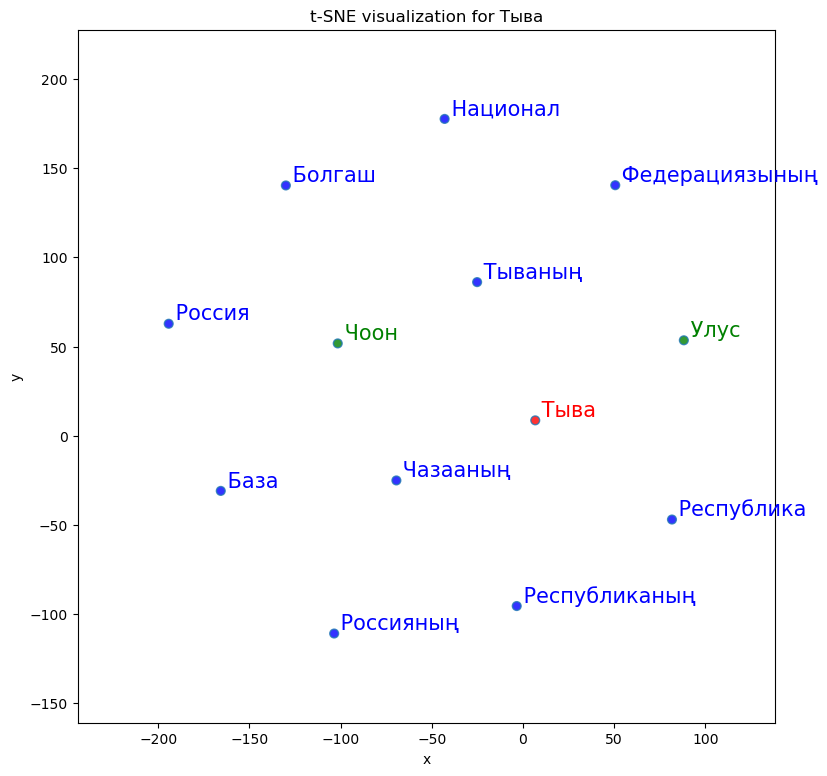

In [110]:
tsne_scatterplot(w2v_model, "тыва", ["улус", "чоон"])